In [1]:
        import tensorflow as tf

        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
          try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
          except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
# 코드 5-16 VGG16 합성곱 기반 층 만들기
from keras.applications import VGG16

conv_base = VGG16(weights="imagenet",
                 include_top = False,
                 input_shape = (150, 150, 3))

In [3]:
 conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
# 코드 5-17 사전 훈련된 합성곱 기반 층을 사용한 특성 추출하기
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "/home/math01/Documents/JT/Keras/deep-learning-with-python-notebooks-master/datasets/cats_and_dogs_small"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                           target_size=(150, 150),
                                           batch_size=batch_size,
                                           class_mode="binary")
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break # 제너레이터는 루프 안에서 무한하게 데이터를 만들어 내므로 모든 데이터를 한 번씩 처리하고 나면 중지
    return features, labels

In [5]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.


In [6]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 2 classes.


In [7]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.


In [8]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [9]:
# 코드 5-18 완전 연결 분류기를 정의하고 훈련하기
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = "relu", input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = "sigmoid"))

In [10]:
model.compile(loss = "binary_crossentropy",
             optimizer = optimizers.RMSprop(lr = 2e-5),
             metrics=["acc"])

In [11]:
history = model.fit(train_features, train_labels,
                   epochs = 30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 0s 5ms/step - acc: 0.6970 - loss: 0.5866 - val_loss: 0.4487 - val_acc: 0.8200
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - acc: 0.7975 - loss: 0.4304 - val_loss: 0.3690 - val_acc: 0.8550
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - acc: 0.8465 - loss: 0.3604 - val_loss: 0.3391 - val_acc: 0.8610
Epoch 4/30
100/100 [==============================] - 1s 5ms/step - acc: 0.8535 - loss: 0.3223 - val_loss: 0.3039 - val_acc: 0.8820
Epoch 5/30
100/100 [==============================] - 1s 5ms/step - acc: 0.8755 - loss: 0.2949 - val_loss: 0.2904 - val_acc: 0.8880
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - acc: 0.8940 - loss: 0.2695 - val_loss: 0.2771 - val_acc: 0.8960
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - acc: 0.9065 - loss: 0.2459 - val_loss: 0.2672 - val_acc: 0.8980
Epoch 8/30
100/100 [==============================] - 0s 5ms/step - acc: 0.9

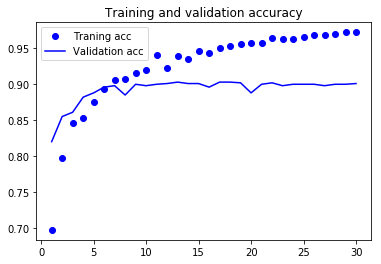

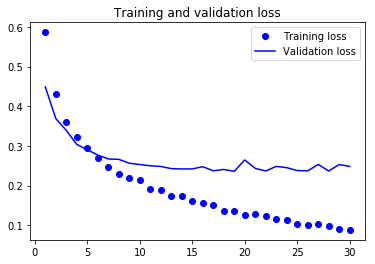

In [13]:
# 코드 5-19 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label = "Traning acc")
plt.plot(epochs, val_acc, "b", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [14]:
# 코드 5-20 합성곱 기반 층 위에 완전 연결 분류기 추가하기
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [16]:
print("conv_base를 동결하기 전 훈련되는 가중치의 수 :",
     len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수 : 30


In [17]:
conv_base.trainable = False

In [18]:
print("conv_base를 동결한 후 훈련되는 가중치의 수 :",
     len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수 : 4


In [19]:
# 코드 5-21 동결된 합성곱 기반 층과 함께 모델을 엔드-투-엔드로 훈련하기
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1./255) # 검증 데이터는 증식되어서는 안됩니다

In [20]:
train_generator = train_datagen.flow_from_directory(train_dir, # 타깃 디렉터리
                                                   target_size=(150, 150), # 모든 이미지의 크기를 150x150크기로 변경합니다
                                                   batch_size = 20,
                                                   class_mode="binary") # binary_crossentropy 손실을 이용하므로 이진 레이블이 필요

validation_generator = test_datagen.flow_from_directory(test_dir,
                                                       target_size=(150, 150),
                                                       batch_size=20,
                                                       class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [21]:
model.compile(loss = "binary_crossentropy",
             optimizer = optimizers.RMSprop(lr = 2e-5),
             metrics = ["acc"])

In [22]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs = 30,
                             validation_data=validation_generator,
                             validation_steps=50,
                             verbose = 2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
100/100 - 9s - acc: 0.7425 - loss: 0.5441 - val_loss: 0.4252 - val_acc: 0.8160
Epoch 2/30
100/100 - 9s - acc: 0.8270 - loss: 0.4070 - val_loss: 0.3475 - val_acc: 0.8560
Epoch 3/30
100/100 - 9s - acc: 0.8550 - loss: 0.3503 - val_loss: 0.3228 - val_acc: 0.8610
Epoch 4/30
100/100 - 9s - acc: 0.8670 - loss: 0.3269 - val_loss: 0.2936 - val_acc: 0.8830
Epoch 5/30
100/100 - 9s - acc: 0.8735 - loss: 0.3015 - val_loss: 0.2854 - val_acc: 0.8810
Epoch 6/30
100/100 - 9s - acc: 0.8765 - loss: 0.2916 - val_loss: 0.2743 - val_acc: 0.8880
Epoch 7/30
100/100 - 9s - acc: 0.8895 - loss: 0.2814 - val_loss: 0.2774 - val_acc: 0.8790
Epoch 8/30
100/100 - 9s - acc: 0.8930 - loss: 0.2619 - val_loss: 0.2810 - val_acc: 0.8870
Epoch 9/30
100/100 - 9s - acc: 0.8905 - loss: 0.2650 - val_loss: 0.2473 - val_acc: 0.9010
Epoch 10/30
100/100 - 9s - acc: 0.9045 - loss: 0.2472 - val_loss: 0.2605 - val_acc: 0.9000
Epoch 11/30
100/100 - 9

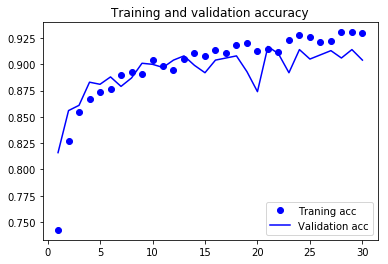

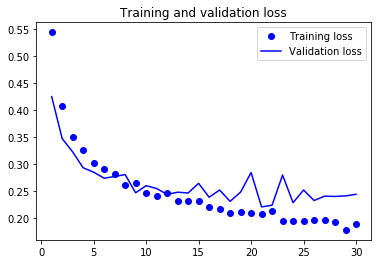

In [23]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label = "Traning acc")
plt.plot(epochs, val_acc, "b", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [24]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [26]:
# 코드 5-22 특정 층까지 모든 층 동결하기
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable =False

In [27]:
# 코드 5-23 모델 미세 조정하기
model.compile(loss = "binary_crossentropy",
             optimizer = optimizers.RMSprop(lr = 1e-5),
             metrics=["acc"])

In [28]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs = 100,
                             validation_data=validation_generator,
                             validation_steps=50)

Epoch 1/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9150 - loss: 0.1914 - val_loss: 0.2997 - val_acc: 0.8870
Epoch 2/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9355 - loss: 0.1503 - val_loss: 0.2578 - val_acc: 0.8920
Epoch 3/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9365 - loss: 0.1494 - val_loss: 0.1689 - val_acc: 0.9340
Epoch 4/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9535 - loss: 0.1228 - val_loss: 0.2320 - val_acc: 0.9060
Epoch 5/100
100/100 [==============================] - 9s 92ms/step - acc: 0.9565 - loss: 0.1067 - val_loss: 0.2158 - val_acc: 0.9190
Epoch 6/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9660 - loss: 0.0919 - val_loss: 0.2043 - val_acc: 0.9310
Epoch 7/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9745 - loss: 0.0772 - val_loss: 0.2154 - val_acc: 0.9210
Epoch 8/100
100/100 [==============================] - 9s 93ms

Epoch 62/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9970 - loss: 0.0136 - val_loss: 0.3369 - val_acc: 0.9350
Epoch 63/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9985 - loss: 0.0022 - val_loss: 0.3810 - val_acc: 0.9300
Epoch 64/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9965 - loss: 0.0086 - val_loss: 0.3459 - val_acc: 0.9350
Epoch 65/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9985 - loss: 0.0038 - val_loss: 0.3768 - val_acc: 0.9380
Epoch 66/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9985 - loss: 0.0027 - val_loss: 0.6353 - val_acc: 0.9100
Epoch 67/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9995 - loss: 0.0019 - val_loss: 0.3992 - val_acc: 0.9330
Epoch 68/100
100/100 [==============================] - 9s 93ms/step - acc: 0.9995 - loss: 0.0040 - val_loss: 0.4174 - val_acc: 0.9340
Epoch 69/100
100/100 [==============================] -

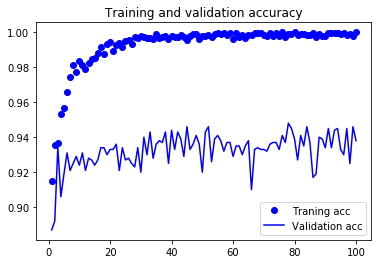

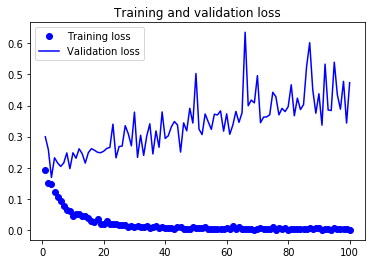

In [29]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label = "Traning acc")
plt.plot(epochs, val_acc, "b", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [30]:
# 코드 5-24 부드러운 그래프 그리기
def smooth_curve(points, factor = 0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previousmoothed_pointstappendtsts_points_points_pointsthed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

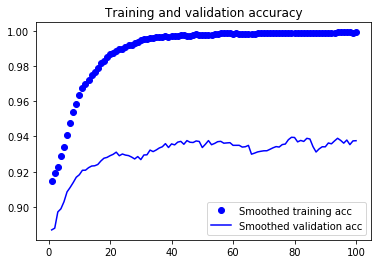

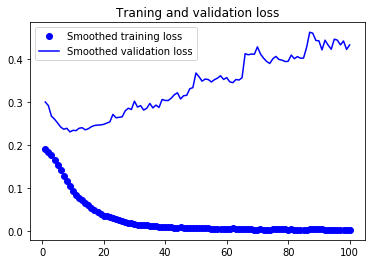

In [31]:
plt.plot(epochs, smooth_curve(acc), "bo", label = "Smoothed training acc")
plt.plot(epochs, smooth_curve(val_acc), "b", label = "Smoothed validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()smooth_curve(epochs, smooth_curve(loss), "bo", label = "Smoothed training loss")
plt.plot(epochs, smooth_curve(val_loss), "b", label = "Smoothed validation loss")
plt.title("Traning and validation loss")
plt.legend()

plt.show()

In [34]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size = (150, 150),
                                                 batch_size = 20,
                                                 class_mode = "binary")

Found 1000 images belonging to 2 classes.


In [35]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps = 50)
print("test acc :", test_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc : 0.9409999847412109
